In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

In [25]:
data=yf.download('0005.hk')

In [ ]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [ ]:
# data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

,Open,High,Low,Close,Adj Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MI6,MI12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,,,,,,,,,,
2022-03-30,53.799999,54.450001,53.750000,53.950001,53.950001,20820331,53.308334,52.045834,69.919360,-20.833320,-10.638296,1.600002,4.350002,52.545739,52.523670,0.022069,0.950001,46.622377,18.475039,54.200001
2022-03-31,53.950001,54.299999,53.799999,54.200001,54.200001,12951991,53.483334,52.462500,71.849555,-14.285714,-6.849312,1.049999,5.000000,52.800241,52.647843,0.152398,0.500000,50.893767,20.961286,54.349998
2022-04-01,53.700001,54.349998,53.400002,54.349998,54.349998,8177523,53.758333,52.891667,73.059622,-6.060739,-2.777840,1.649998,5.149998,53.038665,52.773929,0.264737,0.949997,53.568896,22.508117,54.049999
2022-04-04,54.299999,54.349998,53.799999,54.049999,54.049999,10779509,53.966667,53.129167,66.399654,-24.242494,-12.903266,1.250000,2.849998,53.194255,52.868452,0.325803,0.549999,35.812143,17.491249,53.700001
2022-04-06,53.900002,54.049999,53.150002,53.700001,53.700001,17097274,53.958333,53.320833,59.070435,-57.692342,-31.249980,-0.049999,2.299999,53.272062,52.930049,0.342013,0.899998,16.890204,11.670984,53.450001


In [ ]:
sc = MinMaxScaler(feature_range = (-1, 1))
X=sc.fit_transform(data.drop('Prediction',1))
# X=data.drop('Prediction',1)
Y = data["Prediction"].values.reshape(-1,1)


/tmp/ipykernel_19598/543750826.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [1]:
from sklearn.feature_selection import mutual_info_regression
importance=mutual_info_regression(X,Y)
feature_importances=pd.Series(importance,data.columns[0:len(data.columns)-1])
feature_importances.plot(kind="barh")
plt.title('Information Gain')
plt.show()

NameError: name 'X' is not defined

In [ ]:
# X=sc.fit_transform(data.drop(['Prediction','OSC12','OSC6','MI12','MI6','Volume','%R10','%R5','RSI'],1))
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4889, 1, 19) (4889, 1) (544, 1, 19) (544, 1)


In [ ]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l1(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-09 01:19:14.760473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-09 01:19:14.760740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 01:19:14.760789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-09 01:19:14.760823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-09 01:19:14.760855: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [ ]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
880/880 [==============================] - 5s 4ms/step - loss: 597.5762 - val_loss: 10.5485
Epoch 2/300
880/880 [==============================] - 3s 3ms/step - loss: 8.2654 - val_loss: 4.8231
Epoch 3/300
880/880 [==============================] - 3s 3ms/step - loss: 5.0122 - val_loss: 3.6892
Epoch 4/300
880/880 [==============================] - 3s 3ms/step - loss: 4.1639 - val_loss: 3.8973
Epoch 5/300
880/880 [==============================] - 3s 4ms/step - loss: 3.6888 - val_loss: 4.3328
Epoch 6/300
880/880 [==============================] - 3s 4ms/step - loss: 3.3857 - val_loss: 5.0179
Epoch 7/300
880/880 [==============================] - 3s 3ms/step - loss: 3.1985 - val_loss: 5.3219
Epoch 8/300
880/880 [==============================] - 3s 3ms/step - loss: 3.0741 - val_loss: 5.3750
Epoch 9/300
880/880 [==============================] - 3s 3ms/step - loss: 2.9877 - val_loss: 5.3726
Epoch 10/300
880/880 [==============================] - 3s 3ms/step - loss: 2.9254 - val

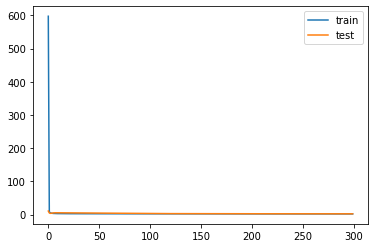

In [ ]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

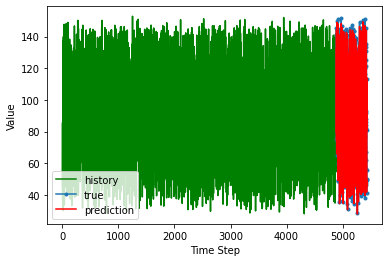

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

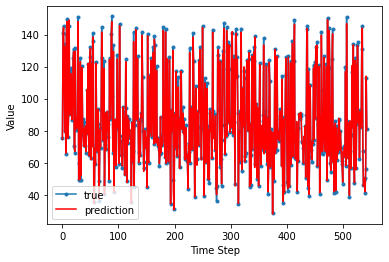

In [ ]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
r2_score(y_test,y_pred)

0.9971655703142831

In [ ]:
mean_absolute_percentage_error(y_test,y_pred)

0.012766183777715748

In [ ]:
mean_squared_error(y_test,y_pred,squared=False)

1.5322622054219672

In [ ]:
x_val=data_val.drop(['Prediction'],1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/tmp/ipykernel_19598/2648236666.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop(['Prediction'],1)


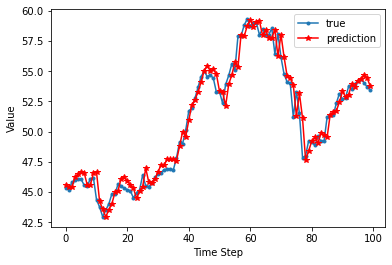

In [ ]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [ ]:
r2_score(y_val,y_val_pred)

0.9611439222524406

In [ ]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.013748665174893156

In [ ]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

0.9305367339943613